In [1]:
import pandas as pd
import numpy as np

# <font color=green> 1. Examine and pre-process data </font>

### The data are cleaned through different stages
1. Eliminates duplicated customer_id from Customer_info datasheet
2. Eliminates unknown referrers (i.e. without Customer_info), and duplicates (i.e. multiple referrals from the same referrer) from the Referral_info datasheet
3. Label referrer = 1, and non-referrer = 0 in Customer_info dataset
4. Merge Referral_info with known referrers data from Customer_info

In [2]:
df1 = pd.read_csv('180601_Customer_Info.csv')
df2 = pd.read_csv('180601_Referrals_Info.csv')

In [3]:
CustomerInfo = df1.drop_duplicates('customer_id') # Drop duplicated customer_id
ref_to_cus_idx = df2.referrer_customer_id.isin(df1.customer_id) # extract idx for referrers's customer_id
RefFirstInfo = df2[ref_to_cus_idx].drop_duplicates('referrer_customer_id') # Drop referral duplicates 
CustomerInfo = CustomerInfo.set_index('customer_id')
CustomerInfo['Referrer'] = 0 *len(CustomerInfo) # Initiate 'referrer' column as 'not a referrer' = 0 
CustomerInfo.Referrer.loc[RefFirstInfo.referrer_customer_id] = 1 # label  'referrer' = 1

print("There are {0} remaining in Customer Information Dataset".format(len(CustomerInfo)) )
CustomerInfo.head(4) 

There are 1698 remaining in Customer Information Dataset


/Users/annapeng/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,sign_up_date,sign_up_channel,Referrer
customer_id,,,
2543,2021-04-26,Price Comparison Website,0
2181,2021-07-24,Referral,0
2399,2020-10-11,Bulb Website,0
674,2021-04-04,Referral,1


### Trim datasets so that both customer_id and referrer_id match, and create a merged dataset containing all referrer's customer information and referral information

In [4]:
Customer_referrer_Info = CustomerInfo.loc[RefFirstInfo.referrer_customer_id]
RefFirstInfo = RefFirstInfo.set_index('referrer_customer_id')
mergedRefInfo = Customer_referrer_Info.merge(RefFirstInfo, left_index = True, right_index = True)
print("There are {0} remaining in Referral Information Dataset".format(len(mergedRefInfo)) )
mergedRefInfo.head(4)

There are 701 remaining in Referral Information Dataset


,sign_up_date,sign_up_channel,Referrer,referral_date,sign_up_customer_id
795,2021-03-03,Price Comparison Website,1,2021-07-18,1771
577,2021-03-28,Price Comparison Website,1,2021-04-12,1510
868,2021-03-07,Bulb Website,1,2021-07-07,1858
801,2021-04-30,Referral,1,2021-10-25,1778


# <font color=green> 2.   Q1: When do members refer? </font>

## Use Bayesian Credible Interval for Probability of First Referral | Mean Membership-in-Days

In [5]:
from scipy import stats
from datetime import *

In [6]:
join_date = map(lambda x: datetime.strptime(x, '%Y-%m-%d'), mergedRefInfo.sign_up_date)
referral_date = map(lambda x: datetime.strptime(x, '%Y-%m-%d'), mergedRefInfo.referral_date)
member_days = list( map(lambda x, y: y-x, join_date, referral_date) )
member_days = list( map(lambda x: x.days, member_days))
mergedRefInfo['member_days'] = member_days

In [7]:
from scipy.stats import norm
dataset= mergedRefInfo.member_days
res_mean, res_var, res_std = stats.bayes_mvs(mergedRefInfo.member_days, alpha=0.9)
print(res_mean, '\n', res_var, '\n', res_std)

Mean(statistic=105.03851640513552, minmax=(97.92134661148347, 112.15568619878756)) 
 Variance(statistic=13127.151805239342, minmax=(12014.192341888811, 14325.461515319763)) 
 Std_dev(statistic=114.53275414378449, minmax=(109.60927124056984, 119.68902002823718))


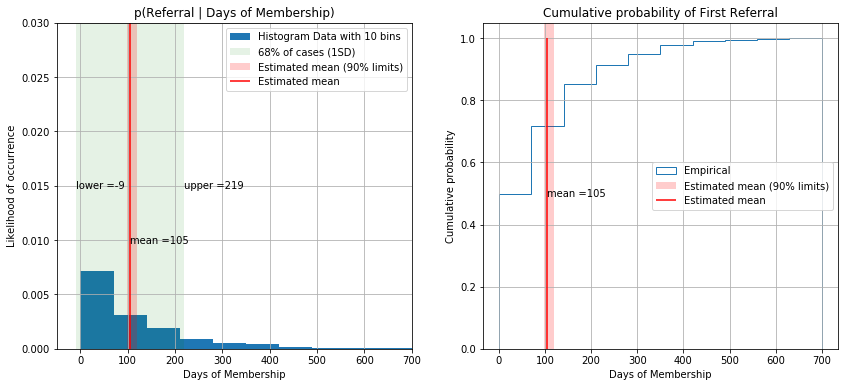

In [10]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import text
n_bins = 10

fig = plt.figure(figsize=(14, 6))

# Histogram of likelihood of a referral given data
ax = fig.add_subplot(121)
ylim = 0.03

lower = res_mean.statistic - res_std.statistic # np.percentile(dataset, 12.5)
upper = res_mean.statistic + res_std.statistic 

ax.hist(dataset, bins=n_bins, density=True, label='Histogram Data with %d bins' %n_bins)
ax.vlines(res_mean.statistic, 0, ylim, colors='r', label='Estimated mean')
ax.axvspan(lower, upper, facecolor='g',
           alpha=0.1, label=r'68% of cases (1SD)')

ax.axvspan(res_mean.minmax[0],res_std.minmax[1], facecolor='r',
           alpha=0.2, label=r'Estimated mean (90% limits)')
ax.grid(True)
ax.legend(fontsize=10)
ax.set_xlim([-50, mergedRefInfo.member_days.max()])
ax.set_ylim([0, ylim])
text(res_mean.statistic, 0.01, "mean =%d" % res_mean.statistic, verticalalignment='center')
text(upper, 0.015, "upper =%d" %upper, verticalalignment='center')
text(lower, 0.015, "lower =%d" %lower, verticalalignment='center')
ax.set_title('p(Referral | Days of Membership)')
ax.set_xlabel('Days of Membership')
ax.set_ylabel('Likelihood of occurrence')


# Culmulative Prob Plot
ax = fig.add_subplot(122)
ax.hist(dataset, n_bins, density=True, histtype='step',
                           cumulative=True, label='Empirical')

ax.vlines(res_mean.statistic, 0, 1, colors='r', label='Estimated mean')
ax.axvspan(res_mean.minmax[0],res_std.minmax[1], facecolor='r',
           alpha=0.2, label=r'Estimated mean (90% limits)')

ax.grid(True)
ax.legend(fontsize=10)
ax.legend(loc='right')
text(res_mean.statistic, 0.5,  "mean =%d" % res_mean.statistic, verticalalignment='center')
ax.set_title('Cumulative probability of First Referral')
ax.set_xlabel('Days of Membership')
ax.set_ylabel('Cumulative probability')

plt.show()

Conclusion: The distribition is positively skewed with the highest probability density around 0 day.
The skew may be caused by both the facts that referrals are most likely during the early days of membership, as well as the fact that most customers are relatively new to Bulb.
The trend suggests that the credible intervals of mean days may not be appropriate to decide on when customer refers.
Instead, using cumulative probability plot, it is possible to infer an optimal range of days from the desired probabilty that captures most of the referral data (such as >80% of data).


# <font color=green> 3.  Q2 analyses:Does the channel members are acquired from significantly impact how they refer? Do you think we need a larger sample size to be sure?</font>

## Method 1: Non-parametric stats to compare whether channels significantly impact days-to-referral, among referrers.

In [11]:
data = mergedRefInfo
data['sign_up_channel'].value_counts()

Referral                    362
Price Comparison Website    181
Bulb Website                158
Name: sign_up_channel, dtype: int64

In [12]:
Group_A = mergedRefInfo[mergedRefInfo.sign_up_channel == 'Referral']
Group_B = mergedRefInfo[mergedRefInfo.sign_up_channel == 'Price Comparison Website']
Group_C = mergedRefInfo[mergedRefInfo.sign_up_channel == 'Bulb Website']
print(stats.kruskal(Group_A.member_days, Group_B.member_days, Group_C.member_days) )
print('-------------------------------------------')
print(' Referral: \n', Group_A.member_days.mean(), '\n', 
      'Price Comp Web: \n', Group_B.member_days.mean(), '\n', 
      'Bulb Web: \n', Group_C.member_days.mean())

KruskalResult(statistic=50.6629733342223, pvalue=9.969540043101382e-12)
-------------------------------------------
 Referral: 
 75.53314917127072 
 Price Comp Web: 
 142.77348066298342 
 Bulb Web: 
 129.41139240506328


In [13]:
for i in (Group_A, Group_B, Group_C):
    for j in (Group_A, Group_B, Group_C):
        if i.member_days.values.tolist() == j.member_days.values.tolist():
            continue
        else:
            print('{0} vs. {1}'.format(i.sign_up_channel.iloc[0], j.sign_up_channel.iloc[0]))
            print(stats.mannwhitneyu(i.member_days, j.member_days))
            print('------------------------------------------')  

Referral vs. Price Comparison Website
MannwhitneyuResult(statistic=21058.5, pvalue=5.573131934944391e-12)
------------------------------------------
Referral vs. Bulb Website
MannwhitneyuResult(statistic=21828.5, pvalue=8.673302547449489e-06)
------------------------------------------
Price Comparison Website vs. Referral
MannwhitneyuResult(statistic=21058.5, pvalue=5.573131934944391e-12)
------------------------------------------
Price Comparison Website vs. Bulb Website
MannwhitneyuResult(statistic=12853.0, pvalue=0.05414819112868531)
------------------------------------------
Bulb Website vs. Referral
MannwhitneyuResult(statistic=21828.5, pvalue=8.673302547449489e-06)
------------------------------------------
Bulb Website vs. Price Comparison Website
MannwhitneyuResult(statistic=12853.0, pvalue=0.05414819112868531)
------------------------------------------


Conclusion: Sign up channels significantly impacted on the time to the first referral (in days).
Referrer customers who signed up through referral channel were significantly quicker in making a referral than referrer customers who signed up through other channels. There were no significant differences in time to the frist referral between Bulb and Price Comparision Websites.

## Method 2: Understand if channel impacts on whether a customer will become a referrer or not with Naive Bayes Classifier

In [14]:
from sklearn.naive_bayes import CategoricalNB
clf = CategoricalNB()
CustomerInfo['sign_up_value']=0*len(CustomerInfo)
CustomerInfo.sign_up_value.loc[CustomerInfo.sign_up_channel == 'Referral'] = 1
CustomerInfo.sign_up_value.loc[CustomerInfo.sign_up_channel == 'Price Comparison Website'] = 2
CustomerInfo.sign_up_value.loc[CustomerInfo.sign_up_channel == 'Bulb Website'] = 3

/Users/annapeng/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [15]:
data = CustomerInfo.Referrer
data = data.to_numpy().reshape(-1,1)
clf.fit(data, CustomerInfo.sign_up_value)
pChannel_given_Ref = clf.predict_proba([[0], [1]])*100
print('''
    Probability of channel, given the the person is a non-referrer:
    Referral: {0:.2f}%, Price Comparison Website: {1:.2f}%, Bulb Website: {2:.2f}% \n
    Probability of channel, given the the person is a referrer:
    Referral: {3:.2f}%, Price Comparison Website: {4:.2f}%, Bulb Website: {5:.2f}%'''.format(
    pChannel_given_Ref[0,0], pChannel_given_Ref[0,1],pChannel_given_Ref[0,2],
    pChannel_given_Ref[1,0], pChannel_given_Ref[1,1],pChannel_given_Ref[1,2]))


    Probability of channel, given the the person is a non-referrer:
    Referral: 20.40%, Price Comparison Website: 60.05%, Bulb Website: 19.56% 

    Probability of channel, given the the person is a referrer:
    Referral: 51.57%, Price Comparison Website: 25.88%, Bulb Website: 22.54%


Conclusion: Given the customer is a non-referrer, the customer is most likely to have signed up through Price Comparison Website. 

Given the customer is a referrer, the customer is most likely to have signed up through referral themselves.

# <font color = green> 4. Q3 We can send an email to members to invite them to refer their friends. We can choose when, and to whom, we send the emails. How would you suggest we proceed? </font>

From the descriptive statistics we know that 
1. Most referrals happened before 219 days since the sign-up, with a mean around 105 days. 
2. Referrals are heavily skewed towards the early days of membership
3. Referrers who signed up through referral channel were quickiest in making referrals.
4. Referrer customers most likely have signed up through referral channel themselves. 
    
Taken as a whole, I would suggest to focus on sending invitation emails to members who signed up through referral channel, from the time when they signed up, to around 100 to 200 days. However the duration of the email campaign is only suggestive from the point of descriptive stats. Due to the large number of new customers, it appears that most first referrals skewed towards early days of membership, and may not reflect an established pattern among the established customers. 

At this stage, it may be more important to focus on the question of whom the invitation should be sent to, rather than the question of when to send it to.

Future analyses and data are needed to establish whether referrers make multiple referrals throughout the membership, at what interval, and what the clustering effect among the referrer networks look like.
    

# <font color = green> Additional Analyses: </font>
# Sample Size analyses 

In [51]:
mergedRefInfo['sign_up_value'] = ""*len(mergedRefInfo)
mergedRefInfo.sign_up_value.loc[mergedRefInfo.sign_up_channel == 'Referral']  =1
mergedRefInfo.sign_up_value.loc[mergedRefInfo.sign_up_channel == 'Price Comparison Website']  =2
mergedRefInfo.sign_up_value.loc[mergedRefInfo.sign_up_channel == 'Bulb Website']  =3

GroupA = mergedRefInfo[mergedRefInfo.sign_up_value==1]
GroupB = mergedRefInfo[mergedRefInfo.sign_up_value ==2]
GroupC = mergedRefInfo[mergedRefInfo.sign_up_value ==3]

p_values = []
for n in range(1,len(GroupA)):
    p_values.append(stats.kruskal(GroupA.member_days.iloc[0:n], GroupB.member_days.iloc[0:n], GroupC.member_days.iloc[0:n])[1]) 




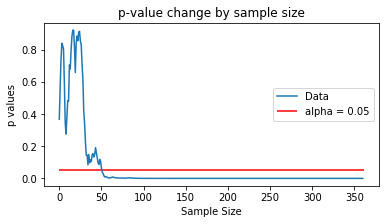

In [60]:
fig = plt.figure(figsize=(6, 3))

# Histogram of likelihood of a referral given data
ax = fig.add_subplot(111)
ax.plot(p_values, label = 'Data')
ax.hlines(0.05, 0, len(p_values), colors='r', label='alpha = 0.05')
ax.set_ylabel('p values')
ax.set_xlabel('Sample Size')
ax.set_title('p-value change by sample size')
ax.legend(fontsize=10)
ax.legend(loc='right')
plt.show()